In [ ]:
# Importing google drive files.

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Importing all necessaries libraries.

from tensorflow.keras import layers, experimental, preprocessing, models

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imghdr
import cv2
import os

In [ ]:
# Creating all necessaries folders.

try:
  os.system("mkdir logs")
  os.system("mkdir models")
  os.system("mkdir real_test")
except:
  print("Something went wrong while creating folders.")
else:
  print("Done.")

Done.


In [ ]:
# Creating legend to the labels.

_label_map = {
    0: "Tumor",
    1: "Healthy"
}

## Preprocessing images.

In [ ]:
# Removing dodgy images.

_main_dir = "/content/drive/MyDrive/Images/Brain Tumor/images"
_img_format = ["png", "jpg", "jpeg"]

for _class_dir in os.listdir(_main_dir):
  for _img in os.listdir(os.path.join(_main_dir, _class_dir)):

    _img_path = os.path.join(_main_dir, _class_dir, _img)

    try:
      _curr_img = cv2.imread(_img_path)
      _img_type = imghdr.what(_img_path)
      if _img_type not in _img_format:
        print(f"Invalid image format: ({_img_type}). Removing {_img_path}..")
        os.remove(_img_path)
    except:
      print(f"Something went wrong while open {_img_path}. Removing image..")
      os.remove(_img_path)

print("Done.")

Done.


In [ ]:
# Resizing images to 640x640.

!python3 /content/drive/MyDrive/scripts/_resize_images_.py --folder /content/drive/MyDrive/Images/Brain\ Tumor/images/Brain\ Tumor --width 640 --height 640
!python3 /content/drive/MyDrive/scripts/_resize_images_.py --folder /content/drive/MyDrive/Images/Brain\ Tumor/images/Healthy --width 640 --height 640

Done.
Done.


In [ ]:
# Limiting tensorflow to use all GPU memory.

_gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in _gpus:
  tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [ ]:
# Load the image data and scaling it. (From 0-255 to 0-1.)

_data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Images/Brain Tumor/images", image_size=(640,640), batch_size=32)
_data = _data.map(lambda x,y: (x/255, y))

_data_iterator = _data.as_numpy_iterator()

Found 4508 files belonging to 2 classes.


In [ ]:
# Gettiing a batch from the data.

_batch = _data_iterator.next()

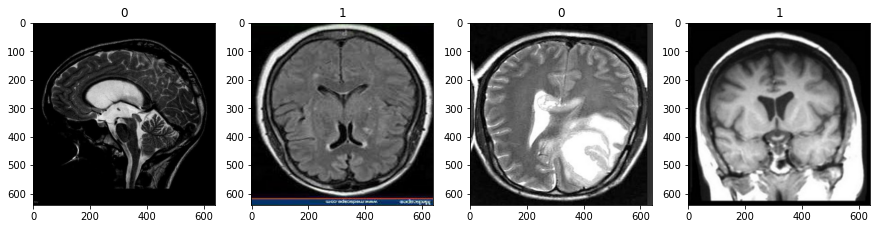

In [ ]:
# Plotting some images and its classes.

fig, ax = plt.subplots(ncols=4, figsize=(15,8))
for i,img in enumerate(_batch[0][:4]):
  ax[i].imshow(img)
  ax[i].title.set_text(_batch[1][i])

# Classes:
> #### Tumor: 0
> #### Healthy: 1

In [ ]:
# Splitting train, test, val data.

_train_size = int(len(_data)*0.7)
_test_size = int(len(_data)*0.2)
_val_size = int(len(_data)*0.1)+1

print("_train_size + _test_size + _val_size = _data?")
print(f"{_train_size} + {_test_size} + {_val_size} = {len(_data)} | {_train_size + _test_size + _val_size == len(_data)}")

_train_size + _test_size + _val_size = _data?
98 + 28 + 15 = 141 | True


In [ ]:
# Taking the splitted data.

_train = _data.take(_train_size)
_test = _data.skip(_train_size).take(_test_size)
_val = _data.skip(_train_size+_test_size).take(_val_size)

In [ ]:
# Creating a callback log.

_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/logs")

In [ ]:
# Builting model.

_model = models.Sequential()
_model.add(layers.Input(shape=_batch[0][0].shape))

# Convolution layers.
_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="relu"))
_model.add(layers.MaxPooling2D())

_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="relu"))
_model.add(layers.MaxPooling2D())

_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, activation="relu"))
_model.add(layers.MaxPooling2D())

_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, activation="relu"))
_model.add(layers.MaxPooling2D())

_model.add(layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, activation="relu"))
_model.add(layers.MaxPooling2D())

# Dense layers.
_model.add(layers.Flatten())

_model.add(layers.Dense(units=512, activation="relu"))
_model.add(layers.Dropout(rate=0.2))

_model.add(layers.Dense(units=128, activation="relu"))

_model.add(layers.Dense(units=1, activation="sigmoid"))

In [ ]:
# Compile model.

_loss = tf.keras.losses.BinaryCrossentropy()
_optimizer = tf.keras.optimizers.Adam()

_model.compile(optimizer=_optimizer, loss=_loss, metrics=["accuracy"])

In [ ]:
# Training model.

_result = _model.fit(x=_train, epochs=20, validation_data=_val, callbacks=_tensorboard_callback)

Epoch 1/20
98/98 [==============================] - 169s 2s/step - loss: 0.5826 - accuracy: 0.6929 - val_loss: 0.4296 - val_accuracy: 0.8130
Epoch 2/20
98/98 [==============================] - 194s 2s/step - loss: 0.3629 - accuracy: 0.8380 - val_loss: 0.2933 - val_accuracy: 0.8887
Epoch 3/20
98/98 [==============================] - 194s 2s/step - loss: 0.2535 - accuracy: 0.8900 - val_loss: 0.2020 - val_accuracy: 0.9097
Epoch 4/20
98/98 [==============================] - 153s 2s/step - loss: 0.1339 - accuracy: 0.9464 - val_loss: 0.1437 - val_accuracy: 0.9517
Epoch 5/20
98/98 [==============================] - 153s 2s/step - loss: 0.0989 - accuracy: 0.9665 - val_loss: 0.1324 - val_accuracy: 0.9559
Epoch 6/20
98/98 [==============================] - 152s 2s/step - loss: 0.0607 - accuracy: 0.9790 - val_loss: 0.0598 - val_accuracy: 0.9769
Epoch 7/20
98/98 [==============================] - 151s 2s/step - loss: 0.0346 - accuracy: 0.9872 - val_loss: 0.0903 - val_accuracy: 0.9769
Epoch 8/20
98

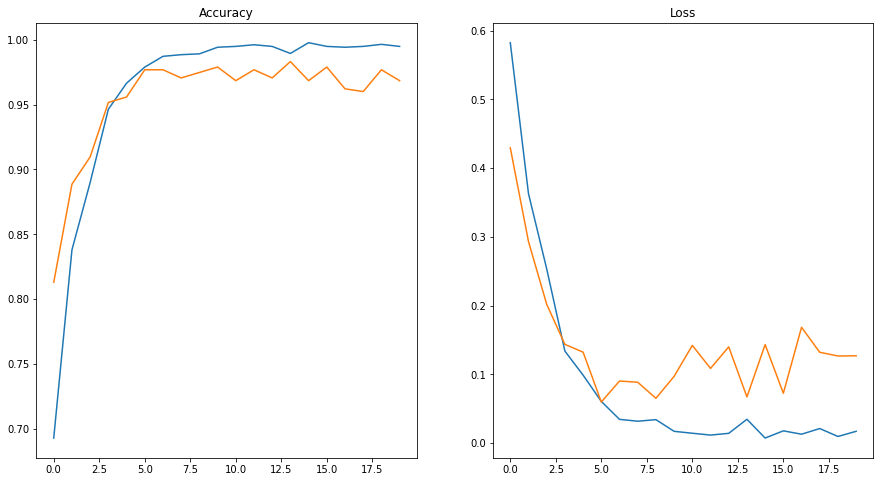

In [ ]:
# Plotting the model accuracy and loss.

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(121)
ax.plot(_result.history["accuracy"], label="train")
ax.plot(_result.history["val_accuracy"], label="val")
ax.title.set_text("Accuracy")

ax = fig.add_subplot(122)
ax.plot(_result.history["loss"], label="train")
ax.plot(_result.history["val_loss"], label="val")
ax.title.set_text("Loss")
plt.show()

In [ ]:
# Creating test batch.

_test_iterator = _test.as_numpy_iterator()
_test_batch = _test_iterator.next()

In [ ]:
# Predicting test data.

_test_pred = _model.predict_on_batch(_test_batch[0])
_test_pred = np.where(_test_pred > .5, 1, 0)

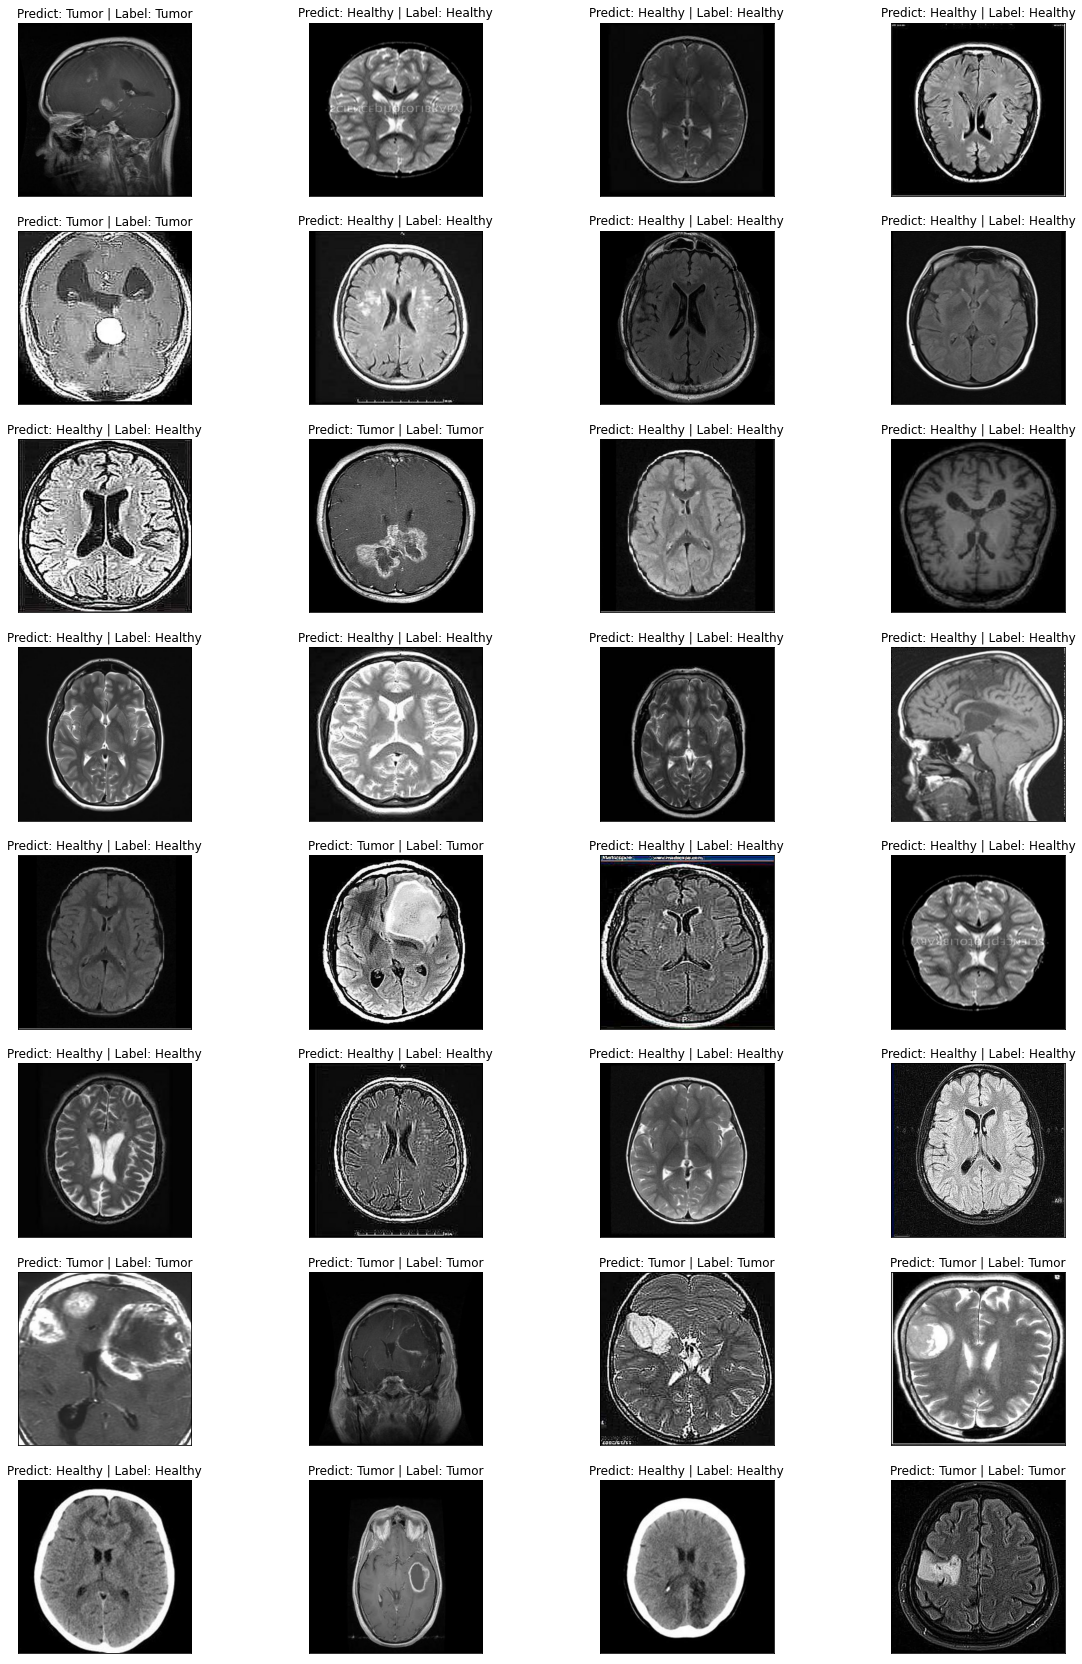

In [15]:
# Plotting the test predicts.

fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(20,30))
i = 0

for c in range(4):
  for r in range(8):
    ax[r][c].imshow(_test_batch[0][i])

    _y = _test_batch[1][i]
    _p = _test_pred[i][0]

    # Changing to text label.
    _y = _label_map[_y]
    _p = _label_map[_p]

    ax[r][c].title.set_text(f"Predict: {_p} | Label: {_y}")
    ax[r][c].get_xaxis().set_visible(False)
    ax[r][c].get_yaxis().set_visible(False)

    i += 1

plt.savefig("cnn-BrainTumorPrediction.png")
plt.show()

# Testing model with new images from internet.

In [ ]:
# Resize image.
!python3 /content/drive/MyDrive/scripts/_resize_images_.py --folder /content/Real\ test --width 640 --height 640

Done.


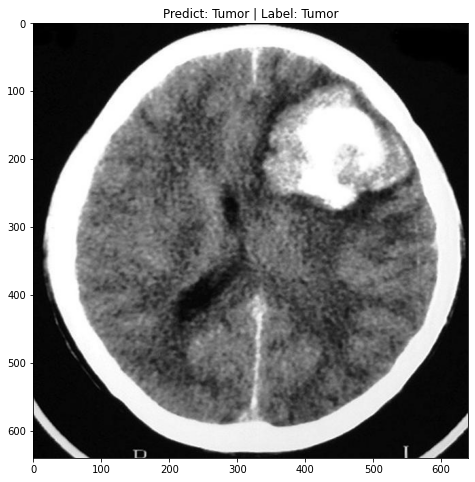

In [ ]:
# Loading image.
_img = cv2.imread("/content/Real test/Dsch30267+.jpg")
_img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

# Set answer and predict.
_y = 0
_p = int(_model.predict_on_batch(tf.expand_dims(_img, 0))[0][0])

# Changing to text label.
_y = _label_map[_y]
_p = _label_map[_p]

# Plotting predict.
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

ax.imshow(_img)
ax.title.set_text(f"Predict: {_p} | Label: {_y}")

plt.show()

In [ ]:
# Saving model.
 
 # On Colab.
_model.save("/content/models")

 # On drive.
_model.save("/content/drive/MyDrive/Models/BrainTumor")

INFO:tensorflow:Assets written to: /content/models/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/BrainTumor/assets


In [ ]:
# Loading model.

_model = tf.keras.models.load_model("/content/drive/MyDrive/Models/BrainTumor")